In [629]:
import numpy as np
import pandas as pd
import json
import glob

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

from sklearn.datasets import load_digits
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

import scipy
from scipy.sparse import hstack

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

In [630]:
## Helper function
def delete_row_csr(mat, i):
    if not isinstance(mat, scipy.sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    n = mat.indptr[i+1] - mat.indptr[i]
    if n > 0:
        mat.data[mat.indptr[i]:-n] = mat.data[mat.indptr[i+1]:]
        mat.data = mat.data[:-n]
        mat.indices[mat.indptr[i]:-n] = mat.indices[mat.indptr[i+1]:]
        mat.indices = mat.indices[:-n]
    mat.indptr[i:-1] = mat.indptr[i+1:]
    mat.indptr[i:] -= n
    mat.indptr = mat.indptr[:-1]
    mat._shape = (mat._shape[0]-1, mat._shape[1])
    
    return(mat)

## The dataset
Now we set up the initial training set for our classifier. I need to pull out a bunch of passages to have a pool to select from.

In [631]:
labeled_files = glob.glob('output/labeled_data/*.csv')
df_labeled = pd.concat((pd.read_csv(f) for f in labeled_files))

ds_files = glob.glob('output/labeled_data/active_learning_labels/data_sharing*.csv')
od_files = glob.glob('output/labeled_data/active_learning_labels/open_data*.csv')
df_data_sharing_al = pd.concat((pd.read_csv(f) for f in ds_files))
df_open_data_al = pd.concat((pd.read_csv(f) for f in od_files))

df_pmcids = pd.read_csv('data/PMC-ids.csv')

df = pd.concat([df_labeled, df_data_sharing_al, df_open_data_al])
df.reset_index(inplace=True)

/home/riddleta/ac_knowl/ac_knowl/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
/home/riddleta/ac_knowl/ac_knowl/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys
/home/riddleta/ac_knowl/ac_knowl/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4,5,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/riddleta/ac_know

In [632]:
#add some manuscript-level information
df['pmcid'] = df.pmcid.astype('str')
df['offset'] = df.paper_offset.astype('str')
df_pmcids['pmcid'] = df_pmcids.PMCID.apply(lambda x: str(x)[3:])
df = df.merge(df_pmcids, how='left', on='pmcid')
df['pmcid-offset'] = df.apply(lambda x: x['pmcid']+'-'+x['offset'], axis=1)

In [633]:
nimh_papers = pd.read_csv('output/nimh_papers.csv')
#load file index
file_ix = pd.read_csv('output/file_index.csv')

/home/riddleta/ac_knowl/ac_knowl/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [634]:
#pull a sample of papers for the "pool" to learn from
sampled_papers = pd.Series(nimh_papers.pmcid.unique()).sample(3000, replace=False)
sampled_papers.shape

(3000,)

In [635]:
#file_locs = file_ix[file_ix.pmcid.isin(nimh_papers.pmcid.unique())]
file_locs = file_ix[file_ix.pmcid.isin(sampled_papers.unique().tolist())]
file_locs.shape

(2681, 3)

In [636]:
file_locs['pmcid'] = file_locs.pmcid.astype('str')
file_locs = file_locs.sort_values('file')

/home/riddleta/ac_knowl/ac_knowl/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [637]:
out_dat = []
last_file = ''
for i, file_path in enumerate(file_locs.file):
    if last_file == file_path:
        paper = dat[file_locs.paper_number.iloc[i]]
        for j in paper['documents'][0]['passages']:
            if 'section_type' in list(j['infons'].keys()):
                if j['infons']['section_type'] != 'REF':
                    pmc_and_offset = file_locs.pmcid.iloc[i] + '-' + str(j['offset'])
                    if pmc_and_offset not in df['pmcid-offset'].tolist():
                        out_dat.append([j['text'], j['offset'], file_locs.pmcid.iloc[i], j['infons']['section_type']])
        last_file = file_path
        
    else:    
        with open(file_path[24:]) as infile:
            dat = json.load(infile)
            paper = dat[file_locs.paper_number.iloc[i]]
            for j in paper['documents'][0]['passages']:
                if 'section_type' in list(j['infons'].keys()):
                    if j['infons']['section_type'] != 'REF':
                        pmc_and_offset = file_locs.pmcid.iloc[i] + '-' + str(j['offset'])
                        if pmc_and_offset not in df['pmcid-offset'].tolist():
                            out_dat.append([j['text'], j['offset'], file_locs.pmcid.iloc[i], j['infons']['section_type']])
            last_file = file_path


In [638]:
df_pool = pd.DataFrame(out_dat, columns=['text', 'offset', 'pmcid', 'section'])
df_pool['pmcid'] = df_pool.pmcid.astype('str')
df_pool = df_pool.merge(df_pmcids, how='left', on='pmcid')
df_pool.shape

(207831, 16)

In [639]:
df.columns

Index(['index', 'data_sharing', 'doi', 'open_data', 'paper_offset', 'pmcid',
       'repo', 'section', 'text', 'offset', 'Journal Title', 'ISSN', 'eISSN',
       'Year', 'Volume', 'Issue', 'Page', 'DOI', 'PMCID', 'PMID',
       'Manuscript Id', 'Release Date', 'pmcid-offset'],
      dtype='object')

## Split data into data sharing and open data sets

In [640]:
df_open_data = df[~pd.isnull(df.open_data)]
df_open_data['open_data'] = df_open_data.open_data.astype('int')
df_open_data.reset_index(inplace=True)
df_open_data.open_data.value_counts()

/home/riddleta/ac_knowl/ac_knowl/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    1167
1     184
Name: open_data, dtype: int64

In [641]:
df_data_sharing = df[~pd.isnull(df.data_sharing)]
df_data_sharing['data_sharing'] = df_data_sharing.data_sharing.astype('int')
df_data_sharing.reset_index(inplace=True)
df_data_sharing.text.fillna('', inplace=True)
df_data_sharing.data_sharing.value_counts()

/home/riddleta/ac_knowl/ac_knowl/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/riddleta/ac_knowl/ac_knowl/lib/python3.7/site-packages/pandas/core/generic.py:6288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


0    1285
1      66
Name: data_sharing, dtype: int64

## Active learning for open data

In [642]:
X = df_open_data.text
y = df_open_data.open_data
#X, y = load_digits(return_X_y=True)

train_x, test_x, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.4)

cv = CountVectorizer()
enc = OneHotEncoder(handle_unknown='ignore')

x_text_train = cv.fit_transform(train_x)
one_hots_train = enc.fit_transform(df_open_data[['section', 'Journal Title', 'Year']].iloc[train_x.index])
y_train = np.array(y_train)
x_text_test = cv.transform(test_x)
one_hots_test = enc.transform(df_open_data[['section', 'Journal Title', 'Year']].iloc[test_x.index])
y_test = np.array(y_test)

x_train = hstack([x_text_train, one_hots_train])
x_test = hstack([x_text_test, one_hots_test])

#X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
x_text_pool = cv.transform(df_pool.text)
x_pool_one_hots = enc.transform(df_pool[['section', 'Journal Title', 'Year']])
x_pool = hstack([x_text_pool, x_pool_one_hots]).tocsr()

In [643]:
x_pool

<207831x10052 sparse matrix of type '<class 'numpy.float64'>'
	with 8612531 stored elements in Compressed Sparse Row format>

### Initializing the learner
Now we initialize the active learner. 

In [644]:
learner = ActiveLearner(
    estimator=AdaBoostClassifier(),
    query_strategy=uncertainty_sampling,
    X_training=x_train, y_training=y_train
)

We also set how many queries we want to make. The more the better! (Usually :) )

In [645]:
f1_score(learner.predict(x_test), y_test)

0.6666666666666667

In [646]:
print(classification_report(learner.predict(x_test), y_test))
print(confusion_matrix(learner.predict(x_test), y_test))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       483
           1       0.59      0.76      0.67        58

    accuracy                           0.92       541
   macro avg       0.78      0.85      0.81       541
weighted avg       0.93      0.92      0.92       541

[[453  30]
 [ 14  44]]


In [647]:
n_queries = 100

## The active learning loop

Results


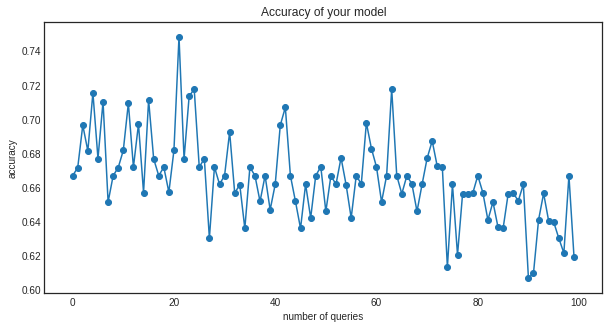

Open Data?
0


In [648]:
accuracy_scores = [f1_score(learner.predict(x_test), y_test)]
queried_data = pd.DataFrame()
labels = []

for i in range(n_queries):
    display.clear_output(wait=True)
    query_idx, query_inst = learner.query(x_pool)
    with plt.style.context('seaborn-white'):
        print(df_pool.text[query_idx].iloc[0])
        plt.figure(figsize=(10, 5))
        plt.title('Accuracy of your model')
        plt.plot(range(i+1), accuracy_scores)
        plt.scatter(range(i+1), accuracy_scores)
        plt.xlabel('number of queries')
        plt.ylabel('accuracy')
        display.display(plt.gcf())
        plt.close('all')

    print("Open Data?")
    y_new = np.array([int(input())], dtype=int)
    learner.teach(query_inst, y_new)
    x_pool = delete_row_csr(x_pool, query_idx[0])
    #X_pool, y_pool = np.delete(X_pool, query_idx, axis=0)#, np.delete(y_pool, query_idx, axis=0)
    accuracy_scores.append(f1_score(learner.predict(x_test), y_test))
    temp = df_pool[['text', 'offset', 'pmcid', 'section', 'DOI']].iloc[query_idx]
    labels.append(y_new[0])
    queried_data = pd.concat([queried_data, temp])

queried_data['open_data'] = labels

In [649]:
queried_data.head()

,text,offset,pmcid,section,DOI,open_data
123574,Lessons derived from this study can be useful ...,28133,3213136,DISCUSS,10.1371/journal.pone.0027447,0
128386,Adropin overexpression does not reduce cholest...,38748,5985041,FIG,10.1016/j.molmet.2017.12.002,0
34413,"However, the amount of available data remains ...",6254,2789920,INTRO,10.1016/j.neuroimage.2009.09.056,0
44595,Twenty four young women were selected from the...,10637,2976801,METHODS,10.1177/1087054710361586,0
101130,,37741,3994700,CONCL,10.1016/j.tig.2009.09.003,0


In [650]:
queried_data.columns = ['text', 'paper_offset', 'pmcid', 'section', 'doi', 'open_data']
queried_data.to_csv('output/labeled_data/active_learning_labels/open_data07.csv', index=False)

## Active learning for data sharing

In [651]:
X = df_data_sharing.text
y = df_data_sharing.data_sharing
#X, y = load_digits(return_X_y=True)

train_x, test_x, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.4)

cv = CountVectorizer(ngram_range=(1,2))
enc = OneHotEncoder(handle_unknown='ignore')

x_text_train = cv.fit_transform(train_x)
one_hots_train = enc.fit_transform(df_data_sharing[['section', 'Journal Title', 'Year']].iloc[train_x.index])
y_train = np.array(y_train)
x_text_test = cv.transform(test_x)
one_hots_test = enc.transform(df_data_sharing[['section', 'Journal Title', 'Year']].iloc[test_x.index])
y_test = np.array(y_test)

x_train = hstack([x_text_train, one_hots_train])
x_test = hstack([x_text_test, one_hots_test])

#X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
x_text_pool = cv.transform(df_pool.text)
x_pool_one_hots = enc.transform(df_pool[['section', 'Journal Title', 'Year']])
x_pool = hstack([x_text_pool, x_pool_one_hots]).tocsr()

In [652]:
x_pool

<207831x57702 sparse matrix of type '<class 'numpy.float64'>'
	with 12940179 stored elements in Compressed Sparse Row format>

### Initializing the learner
Now we initialize the active learner. 

In [653]:
learner = ActiveLearner(
    estimator=AdaBoostClassifier(),
    query_strategy=uncertainty_sampling,
    X_training=x_train, y_training=y_train
)

In [654]:
f1_score(learner.predict(x_test), y_test)

0.4761904761904762

In [655]:
print(classification_report(learner.predict(x_test), y_test))
print(confusion_matrix(learner.predict(x_test), y_test))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       525
           1       0.38      0.62      0.48        16

    accuracy                           0.96       541
   macro avg       0.69      0.80      0.73       541
weighted avg       0.97      0.96      0.96       541

[[509  16]
 [  6  10]]


In [656]:
n_queries = 100

## The active learning loop

System-level effects


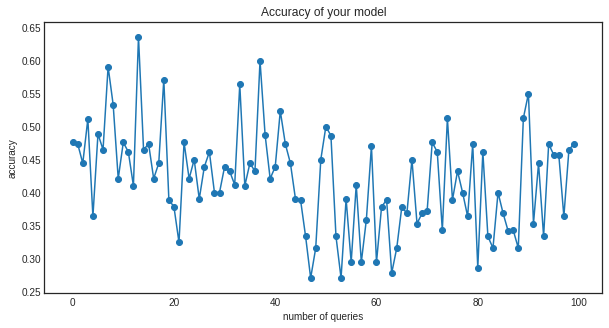

Data Sharing?
0


In [657]:
accuracy_scores = [f1_score(learner.predict(x_test), y_test)]
queried_data = pd.DataFrame()
labels = []

for i in range(n_queries):
    display.clear_output(wait=True)
    query_idx, query_inst = learner.query(x_pool)
    with plt.style.context('seaborn-white'):
        print(df_pool.text[query_idx].iloc[0])
        plt.figure(figsize=(10, 5))
        plt.title('Accuracy of your model')
        plt.plot(range(i+1), accuracy_scores)
        plt.scatter(range(i+1), accuracy_scores)
        plt.xlabel('number of queries')
        plt.ylabel('accuracy')
        display.display(plt.gcf())
        plt.close('all')

    print("Data Sharing?")
    y_new = np.array([int(input())], dtype=int)
    learner.teach(query_inst, y_new)
    x_pool = delete_row_csr(x_pool, query_idx[0])
    #X_pool, y_pool = np.delete(X_pool, query_idx, axis=0)#, np.delete(y_pool, query_idx, axis=0)
    accuracy_scores.append(f1_score(learner.predict(x_test), y_test))
    temp = df_pool[['text', 'offset', 'pmcid', 'section', 'DOI']].iloc[query_idx]
    labels.append(y_new[0])
    queried_data = pd.concat([queried_data, temp])

queried_data['data_sharing'] = labels

In [658]:
queried_data.data_sharing.value_counts()

0    98
1     2
Name: data_sharing, dtype: int64

In [659]:
queried_data.columns = ['text', 'paper_offset', 'pmcid', 'section', 'doi', 'data_sharing']
queried_data.to_csv('output/labeled_data/active_learning_labels/data_sharing07.csv', index=False)

In [552]:
x_train

<598x8367 sparse matrix of type '<class 'numpy.float64'>'
	with 36832 stored elements in COOrdinate format>

In [314]:
df_pool.iloc[query_idx]

,text,offset,pmcid,section,Journal Title,ISSN,eISSN,Year,Volume,Issue,Page,DOI,PMCID,PMID,Manuscript Id,Release Date
83499,\n \n \n Predictor\...,37230,4035109,TABLE,J Clin Psychiatry,0160-6689,1555-2101,2011,72,8,1027,10.4088/JCP.10m06410,PMC4035109,21813075.0,NIHMS317910,live
